In [1]:
pip install xgboost

In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 24.6 MB/s eta 0:00:00


### **Environment SetUp**

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score

# --- NEW: Import visualization libraries ---
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Import all allowed "Part 1" models (for Rule 3)
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [4]:
# Rule 9: Use consistent random seeds
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [6]:
# ---
# Step 1: Setup and Load Data
# ---

# Load data
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

# Keep test IDs for submission
test_ids = test_df['id']

# Drop 'id' from train and test as it's not a feature
train_df = train_df.drop('id', axis=1)
test_df = test_df.drop('id', axis=1)

print("Data loaded successfully.")

Data loaded successfully.


In [7]:
train_df.head(5)

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,WeightCategory
0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


In [8]:
print(f"Feature names : {train_df.columns.to_list()}")

Feature names : ['Gender', 'Age', 'Height', 'Weight', 'family_history_with_overweight', 'FAVC', 'FCVC', 'NCP', 'CAEC', 'SMOKE', 'CH2O', 'SCC', 'FAF', 'TUE', 'CALC', 'MTRANS', 'WeightCategory']


In [9]:
n_classes = len(train_df.WeightCategory.unique())
for index, name in enumerate(sorted(train_df.WeightCategory.unique())):
    print(f"{index+1}. {name}")

1. Insufficient_Weight
2. Normal_Weight
3. Obesity_Type_I
4. Obesity_Type_II
5. Obesity_Type_III
6. Overweight_Level_I
7. Overweight_Level_II


In [10]:
# Checking for NUll values
train_df.isnull().sum()

,0
Gender,0
Age,0
Height,0
Weight,0
family_history_with_overweight,0
FAVC,0
FCVC,0
NCP,0
CAEC,0
SMOKE,0


EDA

Displaying Plot 2: How are Age, Height, and Weight distributed?


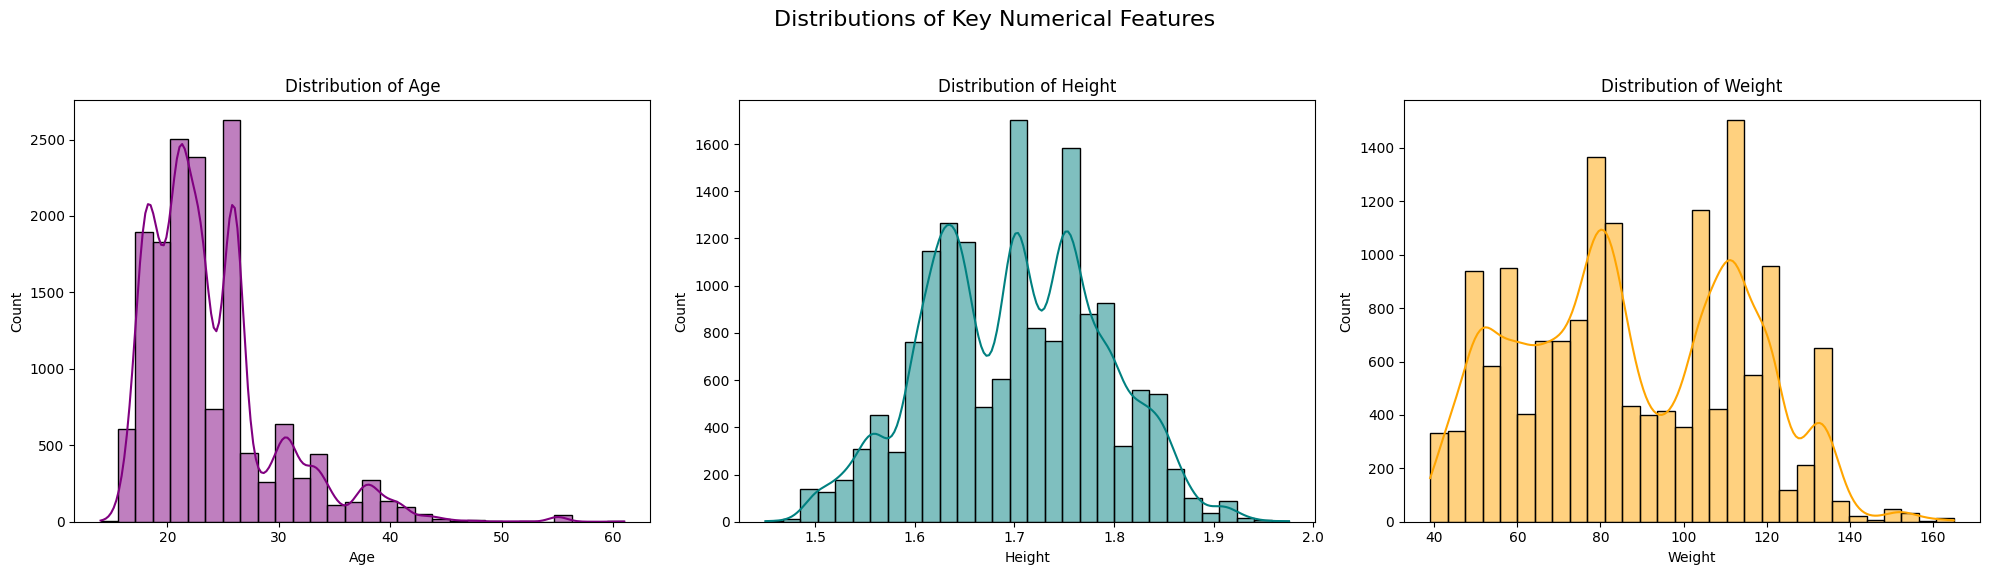

Observation: Age is skewed towards younger people. Height and Weight look reasonable.
Displaying Plot 3: Categorical Feature Counts


/tmp/ipython-input-1600814591.py:40: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1600814591.py:43: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1600814591.py:46: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




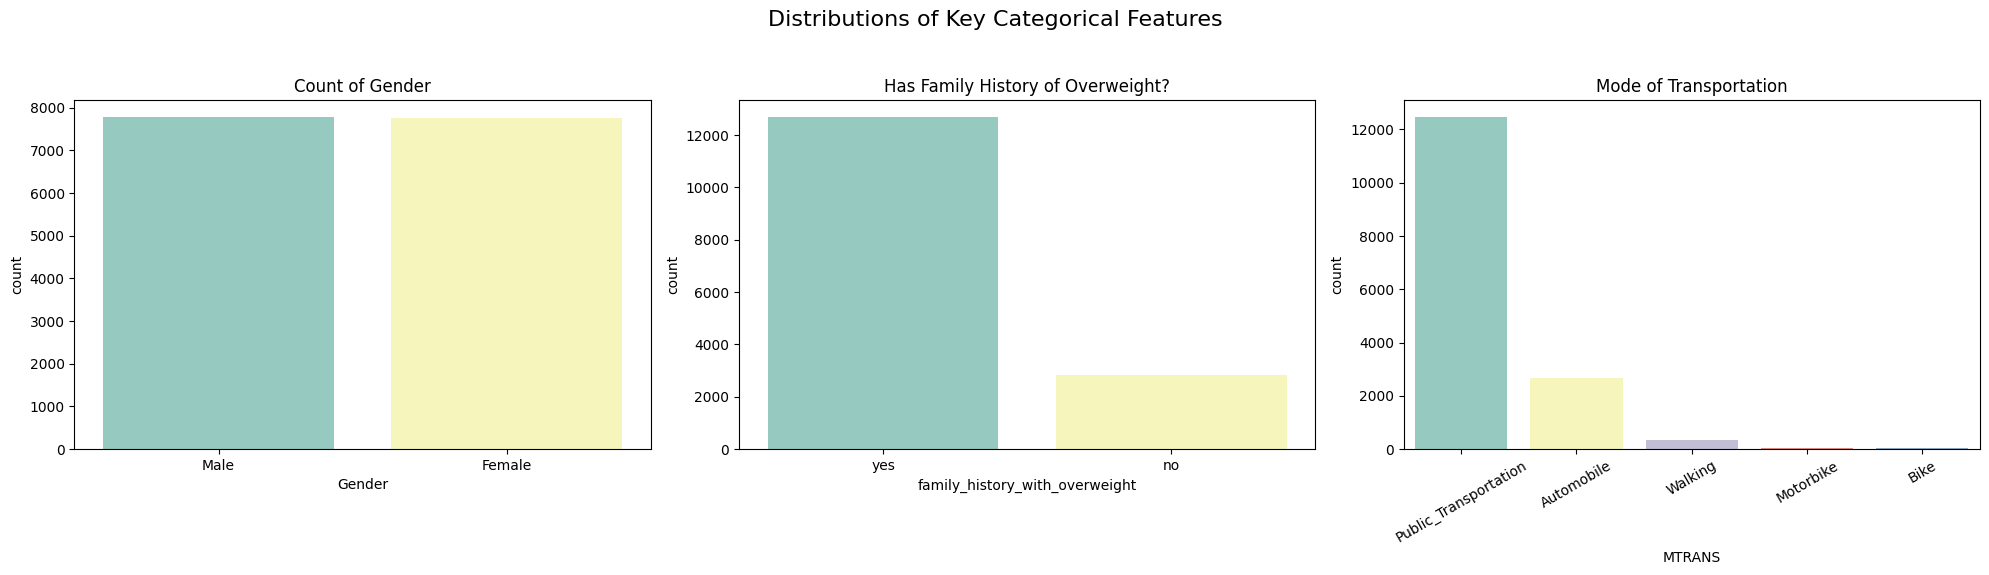

Observation: 'family_history_with_overweight' is 'yes' for most people. 'Public_Transportation' is the most common MTRANS.
Displaying Plot 4: How do Age and Weight relate to the Target?


/tmp/ipython-input-1600814591.py:57: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.


/tmp/ipython-input-1600814591.py:61: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




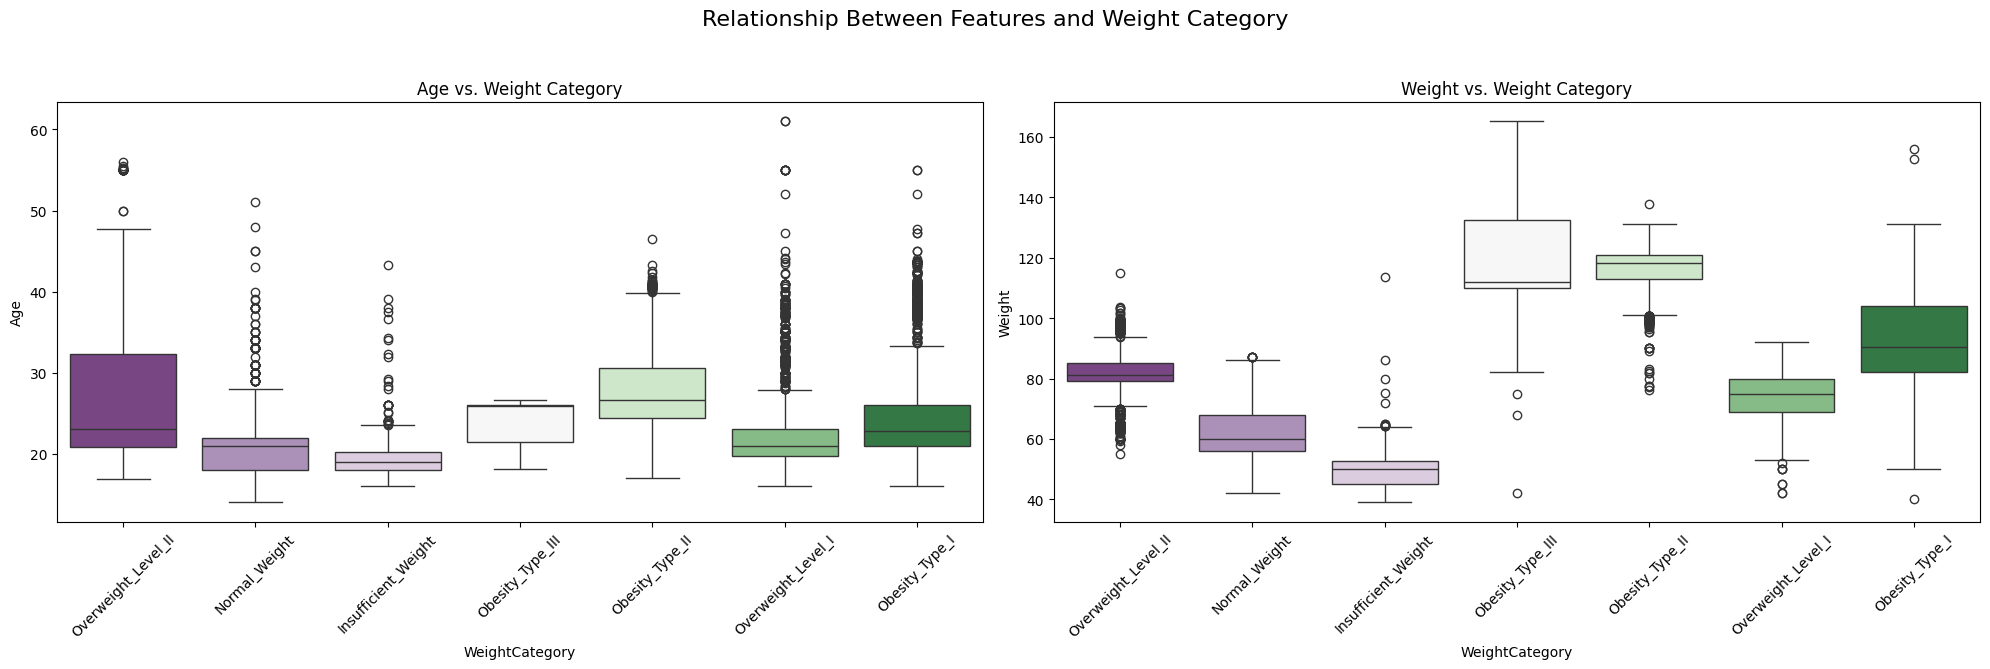

Observation: As expected, 'Weight' is a very strong predictor. 'Age' also shows different distributions for each category.


In [14]:
# Computing the Class Distribution
class_dis = train_df.WeightCategory.value_counts()
names, values = class_dis.index, class_dis.values

# --- Bar Chart ---
bar_chart = px.bar(
    x = names,
    y = values,
    color = names,
    title = "Class Distribution (Bar Graph)",
    color_discrete_sequence=px.colors.qualitative.Set2
)
bar_chart.update_layout(
    showlegend=False,
    xaxis_title = "Class Names",
    yaxis_title = "Frequency Counts"
)
bar_chart.show()

print("Displaying Plot 2: How are Age, Height, and Weight distributed?")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Key Numerical Features', fontsize=16)
# Plot 1: Age
sns.histplot(train_df['Age'], kde=True, ax=axes[0], color='purple', bins=30)
axes[0].set_title('Distribution of Age')
# Plot 2: Height
sns.histplot(train_df['Height'], kde=True, ax=axes[1], color='teal', bins=30)
axes[1].set_title('Distribution of Height')
# Plot 3: Weight
sns.histplot(train_df['Weight'], kde=True, ax=axes[2], color='orange', bins=30)
axes[2].set_title('Distribution of Weight')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Observation: Age is skewed towards younger people. Height and Weight look reasonable.")

print("Displaying Plot 3: Categorical Feature Counts")
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Key Categorical Features', fontsize=16)
# Plot 1: Gender
sns.countplot(data=train_df, x='Gender', ax=axes[0], palette='Set3')
axes[0].set_title('Count of Gender')
# Plot 2: Family History
sns.countplot(data=train_df, x='family_history_with_overweight', ax=axes[1], palette='Set3')
axes[1].set_title('Has Family History of Overweight?')
# Plot 3: Transportation
sns.countplot(data=train_df, x='MTRANS', ax=axes[2], palette='Set3')
axes[2].set_title('Mode of Transportation')
axes[2].tick_params(axis='x', rotation=30)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Observation: 'family_history_with_overweight' is 'yes' for most people. 'Public_Transportation' is the most common MTRANS.")

print("Displaying Plot 4: How do Age and Weight relate to the Target?")
fig, axes = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Relationship Between Features and Weight Category', fontsize=16)
# Plot 1: Age vs Target
sns.boxplot(data=train_df, x='WeightCategory', y='Age', ax=axes[0], palette='PRGn')
axes[0].set_title('Age vs. Weight Category')
axes[0].tick_params(axis='x', rotation=45) # <-- BUG FIX: Removed ha='right'
# Plot 2: Weight vs Target
sns.boxplot(data=train_df, x='WeightCategory', y='Weight', ax=axes[1], palette='PRGn')
axes[1].set_title('Weight vs. Weight Category')
axes[1].tick_params(axis='x', rotation=45) # <-- BUG FIX: Removed ha='right'
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
print("Observation: As expected, 'Weight' is a very strong predictor. 'Age' also shows different distributions for each category.")


In [15]:
# ---
# Step 2: Simple, Manual Preprocessing (Easy to Understand)
# ---

print("\nStarting simple preprocessing...")

target_column = 'WeightCategory'
le = LabelEncoder()
train_df[target_column] = le.fit_transform(train_df[target_column])

binary_map = {'no': 0, 'yes': 1}
gender_map = {'Female': 0, 'Male': 1}
caec_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2, 'Always': 3}
calc_map = {'no': 0, 'Sometimes': 1, 'Frequently': 2} # 'Always' isn't in this column

train_df['family_history_with_overweight'] = train_df['family_history_with_overweight'].map(binary_map)
train_df['FAVC'] = train_df['FAVC'].map(binary_map)
train_df['SMOKE'] = train_df['SMOKE'].map(binary_map)
train_df['SCC'] = train_df['SCC'].map(binary_map)
train_df['Gender'] = train_df['Gender'].map(gender_map)
train_df['CAEC'] = train_df['CAEC'].fillna('Sometimes').map(caec_map) # FillNA to handle missing values
train_df['CALC'] = train_df['CALC'].fillna('no').map(calc_map) # FillNA to handle missing values

test_df['family_history_with_overweight'] = test_df['family_history_with_overweight'].map(binary_map)
test_df['FAVC'] = test_df['FAVC'].map(binary_map)
test_df['SMOKE'] = test_df['SMOKE'].map(binary_map)
test_df['SCC'] = test_df['SCC'].map(binary_map)
test_df['Gender'] = test_df['Gender'].map(gender_map)
test_df['CAEC'] = test_df['CAEC'].fillna('Sometimes').map(caec_map) # FillNA to handle missing values
test_df['CALC'] = test_df['CALC'].fillna('no').map(calc_map) # TYPO FIX (was CALLEC) & FillNA

train_df = pd.get_dummies(train_df, columns=['MTRANS'])
test_df = pd.get_dummies(test_df, columns=['MTRANS'])

train_cols, test_cols = train_df.columns, test_df.columns
missing_in_test = set(train_cols) - set(test_cols)
for c in missing_in_test:
    if c != target_column: # Don't add the target column to test data
        test_df[c] = 0

missing_in_train = set(test_cols) - set(train_cols)
for c in missing_in_train:
    train_df[c] = 0

# Ensure order is the same
test_df = test_df[train_df.drop(target_column, axis=1).columns]

print("Preprocessing complete.")



Starting simple preprocessing...
Preprocessing complete.


Displaying Plot 5: Correlation Heatmap...


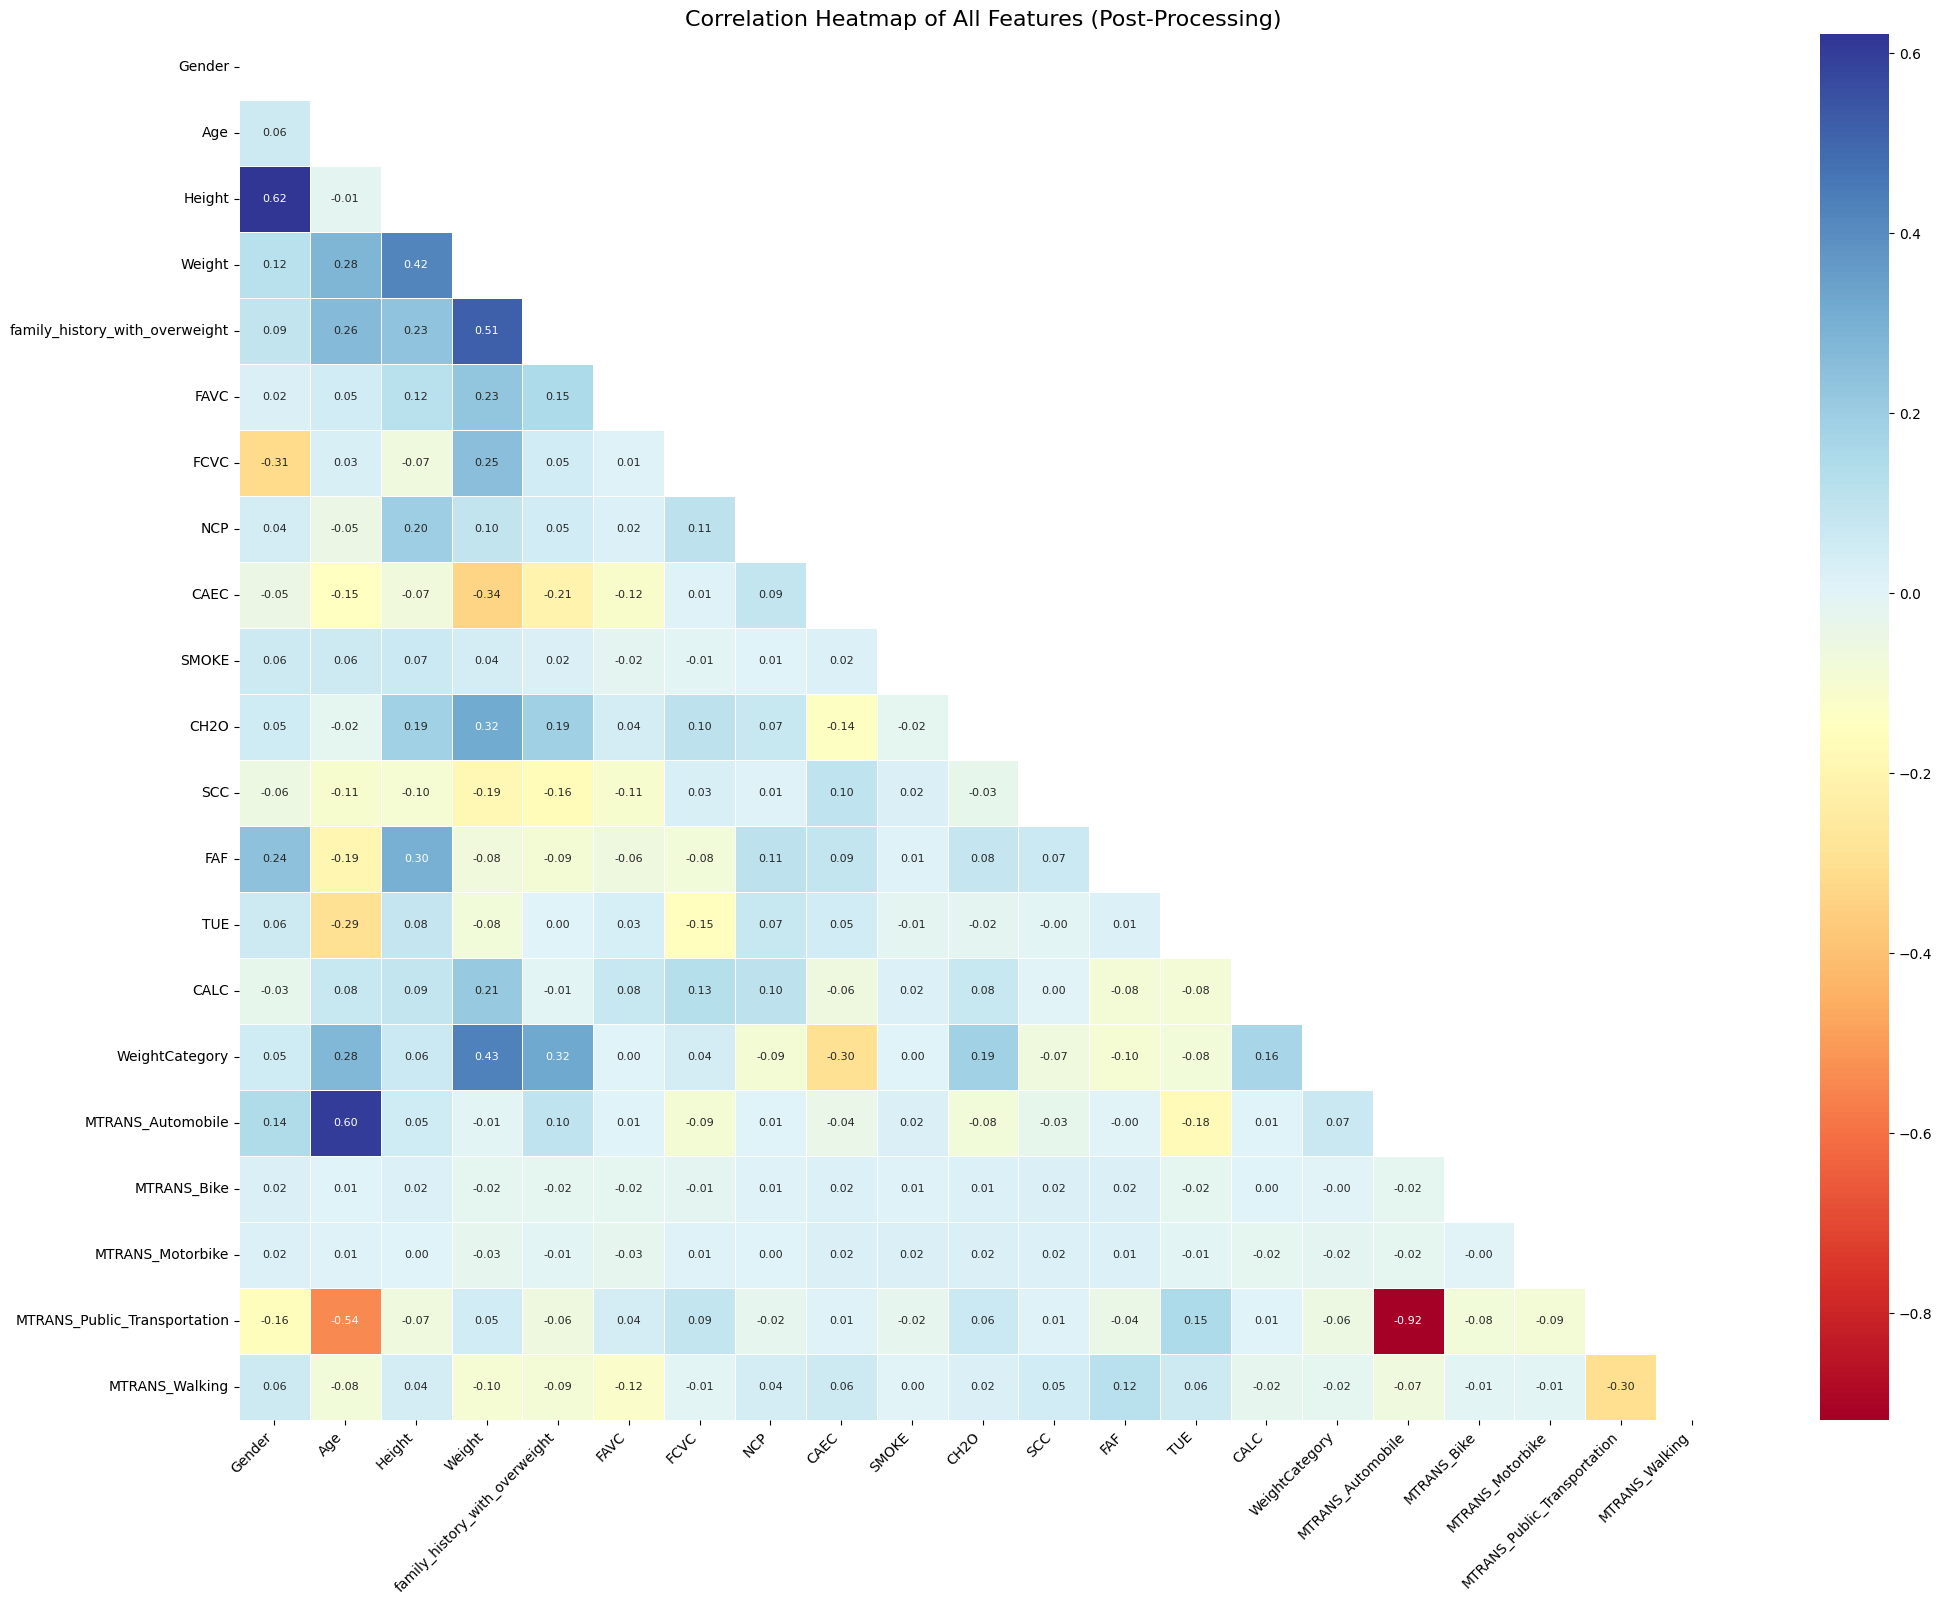

Observation: 'Weight' and 'family_history' have a strong positive correlation with the target. 'Height' also has a notable correlation.


In [16]:
print("Displaying Plot 5: Correlation Heatmap...")
plt.figure(figsize=(24, 18))
corr_matrix = train_df.corr() # This correctly uses the processed 'train_df'
# Mask for upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdYlBu',
    linewidths=0.5,
    annot_kws={"size": 8} # Smaller font size
)
plt.title('Correlation Heatmap of All Features (Post-Processing)', fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()
print("Observation: 'Weight' and 'family_history' have a strong positive correlation with the target. 'Height' also has a notable correlation.")

In [17]:
# ---
# Step 3: Split the Data
# ---

X = train_df.drop(target_column, axis=1)
y = train_df[target_column] # This is now encoded (0, 1, 2...)

X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y
)

In [18]:
# ---
# Step 4: Scale the Numerical Data
# ---

numerical_features = ['Age', 'Height', 'Weight', 'FCVC', 'NCP', 'CH2O', 'FAF', 'TUE']

scaler = StandardScaler()
X_train[numerical_features] = scaler.fit_transform(X_train[numerical_features])
X_val[numerical_features] = scaler.transform(X_val[numerical_features])

print(f"Data split and scaled: {X_train.shape} train, {X_val.shape} validation.")

Data split and scaled: (12426, 20) train, (3107, 20) validation.


In [19]:
# ---
# Step 5: Rule 3 - Comparative Study (Required for Report)
# ---

print("\n--- Starting Rule 3: Comparative Study ---")

models_to_compare = {
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_SEED),
    "Random Forest": RandomForestClassifier(n_jobs=-1, random_state=RANDOM_SEED),
    "AdaBoost": AdaBoostClassifier(random_state=RANDOM_SEED),
    "Gradient Boosting (Sklearn)": GradientBoostingClassifier(random_state=RANDOM_SEED)
}

for name, model in models_to_compare.items():
    print(f"\nTraining {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"--- {name} Validation Accuracy: {accuracy:.4f} ---")

print("\n--- Comparative Study Finished ---")


--- Starting Rule 3: Comparative Study ---

Training Decision Tree...
--- Decision Tree Validation Accuracy: 0.8439 ---

Training Random Forest...
--- Random Forest Validation Accuracy: 0.8928 ---

Training AdaBoost...
--- AdaBoost Validation Accuracy: 0.6611 ---

Training Gradient Boosting (Sklearn)...
--- Gradient Boosting (Sklearn) Validation Accuracy: 0.9022 ---

--- Comparative Study Finished ---


In [20]:
# ---
# Step 6: XGBoost + Optuna Hyperparameter Tuning
# ---

def objective(trial):
    params = {
        'objective': 'multi:softmax',
        'num_class': len(le.classes_),
        'eval_metric': 'mlogloss',
        'n_jobs': -1,
        'random_state': RANDOM_SEED,
        'tree_method': 'hist',
        'early_stopping_rounds': 50,

        # *** A STRONGER, ANTI-OVERFITTING SEARCH SPACE ***
        'n_estimators': trial.suggest_int('n_estimators', 1400, 1500), # More trees
        'learning_rate': 0.3, #  User-specified learning rate
        'max_depth': trial.suggest_int('max_depth', 5, 7), # Force simpler trees
        'subsample': trial.suggest_float('subsample', 0.8, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 0.75),
        'reg_alpha': trial.suggest_float('reg_alpha', 1.5, 4.5, log=True), # Force more regularization
        'reg_lambda': trial.suggest_float('reg_lambda', 0.2, 0.9, log=True), # Force more regularization
        'min_child_weight': trial.suggest_int('min_child_weight', 8, 17) # Add anti-overfitting param
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    trial.set_user_attr("best_iteration", model.best_iteration)
    return accuracy

optuna.logging.set_verbosity(optuna.logging.WARNING)
study = optuna.create_study(direction='maximize')

n_trials_total = 400
print(f"Running Optuna optimization (n_trials={n_trials_total}, n_jobs=-1)...")
study.optimize(objective, n_trials=n_trials_total, show_progress_bar=True, n_jobs=-1)

print("\n--- Optuna Tuning Finished ---")
print(f"Best validation accuracy: {study.best_value:.4f}")
print("Best hyperparameters found:")
print(study.best_params)

Running Optuna optimization (n_trials=400, n_jobs=-1)...


  0%|          | 0/400 [00:00<?, ?it/s]


--- Optuna Tuning Finished ---
Best validation accuracy: 0.9112
Best hyperparameters found:
{'n_estimators': 1419, 'max_depth': 7, 'subsample': 0.8836190501845862, 'colsample_bytree': 0.7065214650886985, 'reg_alpha': 1.6169018295624835, 'reg_lambda': 0.23286139930735797, 'min_child_weight': 13}


In [21]:
# ---
# Step 7: Final Model Training and Submission
# ---

print("\n--- Creating Final Submission File ---")

# 1. Get the best hyperparameters
final_params = study.best_params
final_params['n_estimators'] = study.best_trial.user_attrs["best_iteration"]
final_params.pop('early_stopping_rounds', None)

# 2. Create the final XGBoost model
final_model = xgb.XGBClassifier(
    objective='multi:softmax',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    n_jobs=-1,
    random_state=RANDOM_SEED,
    tree_method='hist',
    **final_params
)

# 3. Prepare the FULL dataset for final training
X_full_scaled = X.copy()
test_df_scaled = test_df.copy()

final_scaler = StandardScaler()
X_full_scaled[numerical_features] = final_scaler.fit_transform(X[numerical_features])
test_df_scaled[numerical_features] = final_scaler.transform(test_df[numerical_features])

# 4. Train on ALL data (X_full_scaled, y)
print("Training final model on ALL training data...")
final_model.fit(X_full_scaled, y)
print("Final model training complete.")

# 5. Make predictions on the test data
print("Making predictions on test data...")
test_predictions_encoded = final_model.predict(test_df_scaled)

# 6. Decode the predictions back to strings (e.g., 'Normal_Weight')
test_predictions_strings = le.inverse_transform(test_predictions_encoded)

# 7. Create submission file
submission_df = pd.DataFrame({
    'id': test_ids,
    'WeightCategory': test_predictions_strings
})

# 8. Save the file
submission_df.to_csv('submission.csv', index=False)

print("\n--- Submission file 'submission.csv' created successfully! ---")
print(submission_df.head())



--- Creating Final Submission File ---
Training final model on ALL training data...
Final model training complete.
Making predictions on test data...

--- Submission file 'submission.csv' created successfully! ---
      id       WeightCategory
0  15533     Obesity_Type_III
1  15534   Overweight_Level_I
2  15535  Overweight_Level_II
3  15536      Obesity_Type_II
4  15537        Normal_Weight
